In [131]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, normalize
import sys
import sklearn.gaussian_process as gp
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [109]:
def getData(fips):
    '''
    # Cleaning and retrieving symptoms data
    symG = pd.read_csv('covidsymptoms/covidsymptoms_google.csv')
    symG = symG.loc[symG['fips'] == float(fips)]
    cols = [0,2,3]
    symG = symG.drop(symG.columns[cols], axis=1)
    
    # Cleaning and retrieving symptoms data
    symFB = pd.read_csv('covidsymptoms/covidsymptoms_fb.csv')
    symFB = symFB.loc[symFB['geo_value'] == float(fips)]
    cols = [0,2,3]
    symFB = symFB.drop(symFB.columns[cols], axis=1)
    
    # Cleaning and retrieving testing rate data
    tes = pd.read_csv('testingrates/testing_rates_county.csv')
    tes = tes.loc[tes['fips'] == float(fips)]
    cols = [0]
    tes = tes.drop(tes.columns[cols], axis=1)
    
    # Cleaning and retrieving demographics data
    dem = pd.read_csv('countydemographics/county_demographics.csv')
    dem = dem.loc[dem['fips'] == float(fips)]
    cols = [0,2,3,4,5,6,8,9,10,11]
    dem = dem.drop(dem.columns[cols], axis=1)
    med_age = dem['median_age'].values[0]
    pop_den = dem['Density per square mile of land area'].values[0]
    '''
    # Cleaning and retrieving mobility data
    mob = pd.read_csv('applemobilitydata/applemobilitycleaned_county.csv')
    mob = mob.loc[mob['fips'] == float(fips)]
    cols = [0,2,3]
    mob = mob.drop(mob.columns[cols], axis=1)
    
    # Cleaning and retrieving GHT data
    ght = pd.read_csv('covidsymptoms/googlehealthtrends.csv')
    ght = ght.loc[ght['fips'] == float(fips)]
    cols = [0,2,3]
    ght = ght.drop(ght.columns[cols], axis=1)
    
    # Cleaning and retrieving doctor visits data
    doc = pd.read_csv('covidsymptoms/doctorvisits.csv')
    doc = doc.loc[doc['fips'] == float(fips)]
    cols = [0,2,3]
    doc = doc.drop(doc.columns[cols], axis=1)
    
    # Cleaning and retrieving case data
    cas = pd.read_csv('covidstats/confirmed_cases_county.csv')
    cas = cas.loc[cas['fips'] == float(fips)]
    cols = [0]
    cas = cas.drop(cas.columns[cols], axis=1)
    
    if mob.shape[0] == 0 or ght.shape[0] == 0 or cas.shape[0] == 0:
        print('Missing one or more data for county, please use another county.')
        return None

    return mob, ght, cas, doc

In [110]:
def prepareData(mob, ght, cas, doc):
    
    newX = pd.concat([mob, ght, doc])
    newX = newX.reset_index()
    newX = newX.drop(newX.columns[[0,1]], axis=1)
    
    newY = pd.concat([cas])
    newY = newY.reset_index()
    newY = newY.drop(newY.columns[[0,1]], axis=1)
    
    newX = newX.T
    newY = newY.T
    newX = newX.fillna(0)
    newY = newY.fillna(0)
    
    X = newX[[0,1,2]]
    y = newY[[0]]

    # Moving averages

    X[0] = X[0].rolling(window=7).mean().dropna()
    X[0] = X[0].shift(4).dropna()
    X[1] = X[1].shift(12).dropna()
    X[2] = X[2].shift(12).dropna()
    
    #y = y.rolling(window=7).mean().dropna()
    
    X = X[X.index.isin(y.index)]
    y = y[y.index.isin(X.index)]
    X = X.fillna(0)
    y = y.fillna(0)

    scaleX = StandardScaler().fit(X)
    scaley = StandardScaler().fit(y)
    X = scaleX.transform(X)
    y = scaley.transform(y)
    
    return X, y, scaleX, scaley

In [148]:
def plot(fips, county):
    X, y, scaleX, scaley = prepareData(*getData(fips))

    kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
    regressor = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=False)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
    model = regressor.fit(X_train, y_train)
    
    y_pred = regressor.predict(X_train)
    y_pred = scaley.inverse_transform(y_pred)
    y_train = scaley.inverse_transform(y_train)
    y_pred = y_pred.clip(min=0)

    fig = plt.figure() # figsize=(10,10)
    ax = fig.add_subplot(111)
    ax.plot(y_train.flatten(), label='Actual')
    ax.plot(y_pred.flatten(), label='Predicted')
    ax.set_title(f'{county} [TRAINING DATA]')
    plt.legend()
    plt.xlabel("2020-01-22 to 2020-04-19")
    plt.ylabel("Number of daily cases")
    
    y_pred = regressor.predict(X_test)
    y_pred = scaley.inverse_transform(y_pred)
    y_test = scaley.inverse_transform(y_test)
    y_pred = y_pred.clip(min=0)

    fig = plt.figure() # figsize=(10,10)
    ax = fig.add_subplot(111)
    ax.plot(y_test.flatten(), label='Actual')    
    ax.plot(y_pred.flatten(), label='Predicted')
    ax.set_title(f'{county} [TESTING DATA]')
    plt.legend()
    plt.xlabel("2020-04-20 to 2020-05-27")
    plt.ylabel("Number of cases")

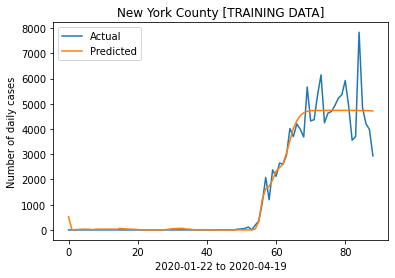

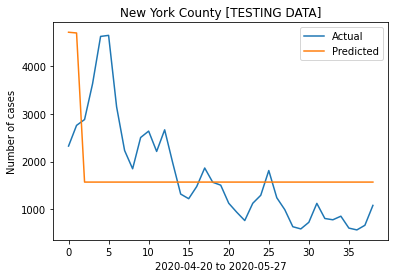

In [149]:
plot('36061', 'New York County')

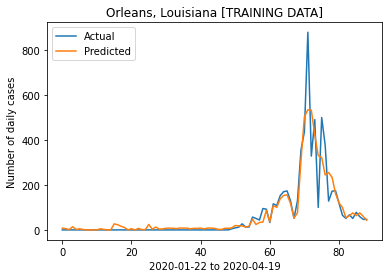

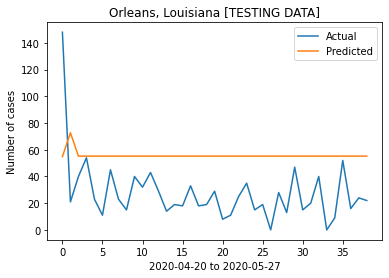

In [150]:
plot('22071', 'Orleans, Louisiana')

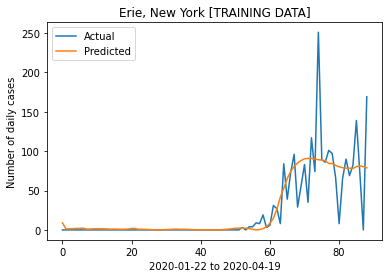

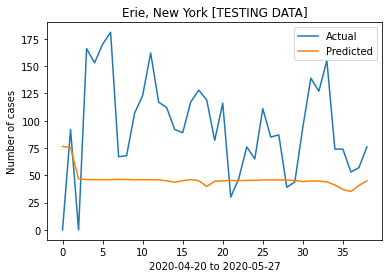

In [151]:
plot('36029', 'Erie, New York')

# Mapping

In [4]:
mappings = {}
def mapping(fips):
    try:
        passed = getData(fips)
    except:
        return None
    
    if not passed:
        return None
    
    X, y, scaleX, scaley = prepareData(*getData(fips))

    kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e3)) * gp.kernels.RBF(10.0, (1e-3, 1e3))
    regressor = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=False)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
    model = regressor.fit(X_train, y_train)
    
    y_pred = regressor.predict(X_test)
    y_pred = scaley.inverse_transform(y_pred)
    y_test = scaley.inverse_transform(y_test)
    y_pred = y_pred.clip(min=0)
    
    gradient = float((y_pred[-1]-y_pred[0])/(len(y_pred)))
    mappings.update({fips:gradient})

In [ ]:
fips = pd.read_csv('county_fips_codes.csv')['fips']
for fip in fips:
    mapping(str(fip))

In [ ]:
mappings

In [78]:
df = pd.DataFrame(mappings.items())

In [79]:
def tanhFunc(x):
  return np.tanh(float(x.values[1]))

In [80]:
df[1] = df.apply(tanhFunc, axis=1)
df.columns = ['fips', 'mapping']

In [82]:
df.to_csv('county_prediction_mapping.csv')